# EBI Metadata - General Insights

In [1]:
import pandas as pd

df = pd.read_csv('../data/metadata_EBI_preprocessed.csv',
                 dtype={'collected_by': object,
                        'collection_date': object,
                        'culture_collection': object,
                        'identified_by': object,
                        'isolate': object,
                        'isolation_source': object,
                        'keywords': object,
                        'lab_host': object,
                        'location': object,
                        'sample_accession': object,
                        'strain': object,
                        'study_accession': object})
df.info()  # 29 + 5 columns, 2.8 mio entries

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2831557 entries, 0 to 2831556
Data columns (total 34 columns):
 #   Column                Dtype  
---  ------                -----  
 0   accession             object 
 1   base_count            int64  
 2   collected_by          object 
 3   collection_date       object 
 4   country_and_region    object 
 5   culture_collection    object 
 6   dataclass             object 
 7   description           object 
 8   environmental_sample  bool   
 9   first_public          object 
 10  germline              bool   
 11  host                  object 
 12  identified_by         object 
 13  isolate               object 
 14  isolation_source      object 
 15  keywords              object 
 16  lab_host              object 
 17  last_updated          object 
 18  location              object 
 19  mol_type              object 
 20  sample_accession      object 
 21  scientific_name       object 
 22  sequence_md5          object 
 23  sequenc

## Descriptive Statistics

In [177]:
import pandas_profiling
import json

# Create fancy profile report
# See https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html for advanced usage
profile_ebi = pandas_profiling.ProfileReport(df,
                                             title='EBI Metadata Profiling',
                                             minimal=True,
                                             correlations={'pearson': {'calculate': True},
                                                           'spearman': {'calculate': True},
                                                           'kendall': {'calculate': True},
                                                           'phi_k': {'calculate': True},
                                                           'cramers': {'calculate': False}})

# Add definitions
with open('json_data/definitions_EBI_metadata.json') as f:
    definitions_ebi_metadata = json.load(f)
profile_ebi.config.variables.descriptions = definitions_ebi_metadata

# Save as html
profile_ebi.to_file(output_file='../data/metadata_EBI_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Investigation of National Bias

In [ ]:
# Separate dataframe into countries appearing often and rarely
threshold = 1000

rare_countries = df[df['country'].map(df['country'].value_counts()) < threshold]
rare_countries['country'].value_counts()

In [ ]:
popular_countries = df[df['country'].map(df['country'].value_counts()) >= threshold]
popular_countries['country'].value_counts()

In [ ]:
with open('json_data/country_inhabitants_map.json') as f:
    country_inhabitants_map = json.load(f)

In [2]:
import os

if not os.path.isdir('../plots/general_country_counts'):
    os.mkdir('../plots/general_country_counts')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Plot distribution of countries appearing more than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(18, 16))
    sns.countplot(data=popular_countries,
                  x='country',
                  hue=hue,
                  order=popular_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with >= 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(popular_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        new_height = patch.get_height() / country_inhabitants_map[country]
        max_y = max(max_y, new_height)
        patch.set_height(new_height)

    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    fig.savefig(f'../plots/general_country_counts/popular_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

In [ ]:
# Plot distribution of countries appearing less than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(36, 18))
    sns.countplot(data=rare_countries,
                  x='country',
                  hue=hue,
                  order=rare_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with < 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(rare_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        if country == 'Unknown':
            new_height = 0.0
        else:
            new_height = patch.get_height() / country_inhabitants_map[country]

        max_y = max(max_y, new_height)
        patch.set_height(new_height)
    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    fig.savefig(f'../plots/general_country_counts/rare_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

## Number of Infections per Country
### Preprocess Time Series Data by JHU

In [2]:
# Taken from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
countries_ts = pd.read_csv('../data/JHU_countries_time_series.csv')
countries_ts.info()  # 280 entries, 723 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Columns: 723 entries, Province/State to 1/9/22
dtypes: float64(2), int64(719), object(2)
memory usage: 1.5+ MB


In [3]:
# Check which countries from EBI metadata do not exist in JHU data
countries_JHU = countries_ts['Country/Region'].unique()
countries_ebi = df['country'].unique()

list(set(countries_ebi) - set(countries_JHU))

[nan,
 'Viet Nam',
 'Czech Republic',
 'Guam',
 'South Korea',
 'Hong Kong',
 'West Bank',
 'USA',
 'Puerto Rico',
 'Myanmar',
 'Taiwan']

In [4]:
# Change countries in JHU data to EBI metadata wording
countries_ts['Country/Region'].replace(['Vietnam', 'West Bank and Gaza', 'US'], ['Viet Nam', 'West Bank', 'USA'], inplace=True)

In [6]:
# Only keep TS data of countries that can be found in EBI metadata too (keep 184 of 280 samples)
countries_ts = countries_ts[countries_ts['Country/Region'].isin(countries_ebi)]

In [8]:
countries_ts['Country/Region'].value_counts()  # -> some countries occur several times and have to be summed up first

China             34
Canada            16
France            12
United Kingdom    12
Australia          8
                  ..
Greece             1
Ghana              1
Germany            1
Georgia            1
Zimbabwe           1
Name: Country/Region, Length: 100, dtype: int64

In [9]:
countries_ts[countries_ts['Country/Region'] == 'China']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22
58,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,1009,1009,1009,1009,1009,1009,1009,1009,1009,1009
59,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,1211,1211,1215,1215,1216,1216,1217,1217,1218,1218
60,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,611,611,611,611,611,611,611,611,611,611
61,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,1363,1372,1372,1383,1390,1396,1397,1401,1410,1415
62,Gansu,China,35.7518,104.2861,0,2,2,4,7,14,...,356,356,356,356,356,356,356,356,356,356
63,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,3457,3467,3467,3486,3493,3503,3512,3521,3530,3539
64,Guangxi,China,23.8298,108.7881,2,5,23,23,36,46,...,622,630,637,641,650,652,656,662,665,668
65,Guizhou,China,26.8154,106.8748,1,3,3,4,5,7,...,160,160,160,160,160,160,160,160,160,160
66,Hainan,China,19.1959,109.7453,4,5,8,19,22,33,...,190,190,190,190,190,190,190,190,190,190
67,Hebei,China,39.5490,116.1306,1,1,2,8,13,18,...,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458


In [11]:
# Get countries whose time series values have to be summed up
countries_to_sum = countries_ts['Country/Region'].value_counts().reset_index(name="count").query("count > 1")["index"]
countries_to_sum

0             China
1            Canada
2            France
3    United Kingdom
4         Australia
5       Netherlands
6           Denmark
7       New Zealand
Name: index, dtype: object

In [10]:
# Exclude first 4 columns (meaning 'Province/State', 'Country/Region', 'Lat' and 'Long')
date_cols = countries_ts.columns.tolist()[4:]
date_cols

['1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/

In [12]:
for country in countries_to_sum:
    country_ts = countries_ts[countries_ts['Country/Region'] == country]
    # Sum up column values for each date column
    country_ts.loc['Country_Total'] = country_ts[date_cols].sum(axis=0)
    # Mark "special" country with suffix
    country_ts.loc['Country_Total', 'Country/Region'] = f'{country}_Sum'
    # Append new row to existing time series data frame
    countries_ts = pd.concat([countries_ts, country_ts], axis=0)

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
# Show example of new row
countries_ts[countries_ts['Country/Region'] == 'China_Sum']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22
Country_Total,NaN,China_Sum,NaN,NaN,548.0,643.0,920.0,1406.0,2075.0,2877.0,...,115042.0,115251.0,115409.0,115597.0,115701.0,115908.0,116106.0,116282.0,116468.0,116641.0


In [14]:
# Filter for countries that appear only one time (which is also true for countries that appeared several times before because suffix "_Sum" makes country name unique)
relevant_countries = countries_ts['Country/Region'].value_counts().reset_index(name="count").query("count == 1")["index"]
countries_ts = countries_ts[countries_ts['Country/Region'].isin(relevant_countries)]

# Remove suffix after filtering of relevant countries and reset index
countries_ts['Country/Region'] = countries_ts['Country/Region'].str.replace('_Sum', '')
countries_ts.reset_index(drop=True, inplace=True)

In [15]:
countries_ts['Country/Region'].nunique()  # -> EBI metadata contains 7 countries more

100

In [17]:
countries_ts.to_csv('../data/JHU_countries_time_series_preprocessed.csv', index=False)

### Number of Samples in Relation to Current Number of Infections per Country

In [33]:
countries_ts = pd.read_csv('../data/JHU_countries_time_series_preprocessed.csv')

In [21]:
# Get count of each country
country_counts = pd.DataFrame(df['country'].value_counts().sort_index().reset_index())
country_counts.rename(columns={'index': 'Country', 'country': 'Count'}, inplace=True)
country_counts

,Country,Count
0,Argentina,43
1,Armenia,48
2,Australia,13311
3,Austria,261
4,Bahrain,3304
...,...,...
102,Venezuela,40
103,Viet Nam,11
104,West Bank,63
105,Zambia,1


In [23]:
import numpy as np

def add_infection(country):
    if country in countries_ts['Country/Region'].unique():
        return countries_ts[countries_ts['Country/Region'] == country]['1/9/22'].iloc[0]
    else:
        return np.nan

country_counts['Infections'] = country_counts.apply(lambda row: add_infection(str(row['Country'])), axis=1)
country_counts

,Country,Count,Infections
0,Argentina,43,6310844.0
1,Armenia,48,345855.0
2,Australia,13311,1045291.0
3,Austria,261,1339421.0
4,Bahrain,3304,292572.0
...,...,...,...
102,Venezuela,40,447288.0
103,Viet Nam,11,1899575.0
104,West Bank,63,471414.0
105,Zambia,1,282904.0


In [24]:
# Add column showing #samples/#infections ratio per country
country_counts['Count_Infection_Ratio'] = country_counts['Count'] / country_counts['Infections']
country_counts

,Country,Count,Infections,Count_Infection_Ratio
0,Argentina,43,6310844.0,0.000007
1,Armenia,48,345855.0,0.000139
2,Australia,13311,1045291.0,0.012734
3,Austria,261,1339421.0,0.000195
4,Bahrain,3304,292572.0,0.011293
...,...,...,...,...
102,Venezuela,40,447288.0,0.000089
103,Viet Nam,11,1899575.0,0.000006
104,West Bank,63,471414.0,0.000134
105,Zambia,1,282904.0,0.000004


In [25]:
# Remove countries that did not occur in time series data from JHU
plotdata = country_counts[country_counts['Infections'] != np.nan]

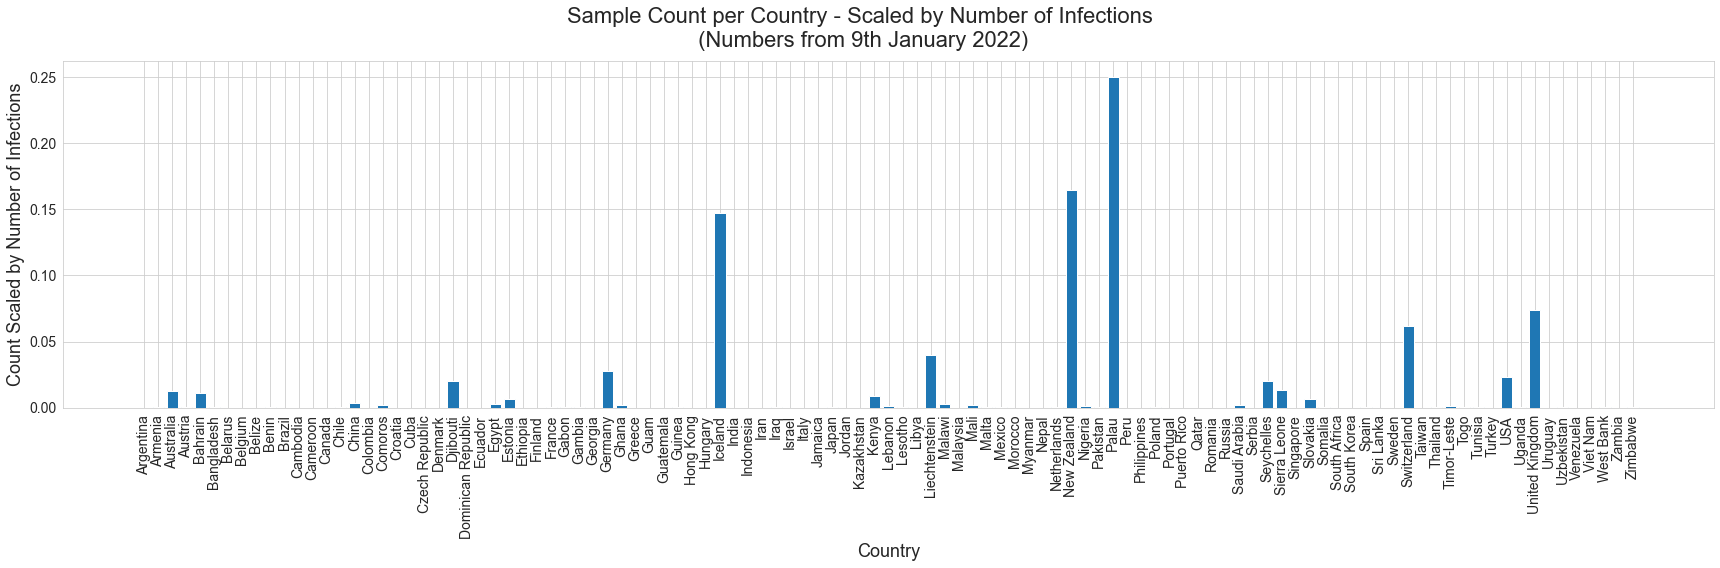

In [29]:
# Generate bar plots with #samples/#infections on y-axis and countries on x-axis
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 8))
plt.bar(plotdata['Country'].tolist(), plotdata['Count_Infection_Ratio'].tolist())

fig.suptitle('Sample Count per Country - Scaled by Number of Infections\n (Numbers from 9th January 2022)', fontsize=22)
plt.xlabel('Country', fontsize=18)
plt.ylabel('Count Scaled by Number of Infections', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/country_counts_by_infections.png', dpi=300)
plt.close()

### Number of Samples in Relation to Number of Infections per Country: Week-wise over Time

In [34]:
# Remove some date columns to start on first Monday of February 2020
countries_ts = countries_ts.drop(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',                       # remove fourth week
                                  '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20'],  # remove fifth week
                                 axis=1)
countries_ts.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '2/3/20', '2/4/20',
       '2/5/20', '2/6/20', '2/7/20', '2/8/20',
       ...
       '12/31/21', '1/1/22', '1/2/22', '1/3/22', '1/4/22', '1/5/22', '1/6/22',
       '1/7/22', '1/8/22', '1/9/22'],
      dtype='object', length=711)

In [39]:
# Sum up infection count per week (starting with week from 2/3/20)
for i, date_col in enumerate(countries_ts.columns[4:711:7]):
    countries_ts[f'{date_col}_Week'] = countries_ts.iloc[:, i*7 : i*7 + 7].sum(axis=1)

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
countries_ts[['Country/Region', '1/3/22', '1/4/22', '1/5/22', '1/6/22', '1/7/22', '1/8/22', '1/9/22', '1/3/22_Week']]

,Country/Region,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/3/22_Week
0,Argentina,5739326.0,5820536.0,5915695.0,6025303.0,6135836.0,6237525.0,6310844.0,40106068.0
1,Armenia,345036.0,345126.0,345255.0,345389.0,345518.0,345713.0,345855.0,2415160.0
2,Austria,1288829.0,1294325.0,1304086.0,1312939.0,1321725.0,1329130.0,1339421.0,9008591.0
3,Bahrain,284224.0,285448.0,286529.0,287939.0,289454.0,290878.0,292572.0,1985690.0
4,Bangladesh,1587140.0,1587915.0,1588807.0,1589947.0,1591093.0,1592209.0,1593700.0,11106803.0
...,...,...,...,...,...,...,...,...,...
95,United Kingdom,13497515.0,13723275.0,13918510.0,14100750.0,14280816.0,14422067.0,14563769.0,93455720.0
96,Australia,537308.0,608803.0,684229.0,762458.0,860550.0,972457.0,1045291.0,3583940.0
97,Netherlands,3234143.0,3254947.0,3282146.0,3309168.0,3346598.0,3376251.0,3410288.0,22538032.0
98,Denmark,849334.0,874890.0,903652.0,929647.0,948499.0,961591.0,982189.0,5902650.0


In [41]:
# Keep weekly data and country
plotdata_infections = countries_ts.filter(regex='_Week$|Country/Region', axis=1)
# Remove suffix from date column names for interpretability on x-axis later on
plotdata_infections.columns = plotdata_infections.columns.str.replace('_Week', '')

plotdata_infections.head(10)

,Country/Region,2/3/20,2/10/20,2/17/20,2/24/20,3/2/20,3/9/20,3/16/20,3/23/20,3/30/20,...,11/1/21,11/8/21,11/15/21,11/22/21,11/29/21,12/6/21,12/13/21,12/20/21,12/27/21,1/3/22
0,Argentina,-102.032800,0.0,0.0,0.0,2.0,71.0,332.0,1724.0,5454.0,...,37024366.0,37080690.0,37143671.0,37209235.0,37289967.0,37390578.0,37520477.0,37750017.0,38337405.0,40106068.0
1,Armenia,85.107300,0.0,0.0,0.0,4.0,7.0,270.0,1354.0,3035.0,...,2154761.0,2238938.0,2299544.0,2337248.0,2364446.0,2384018.0,2397172.0,2405199.0,2411173.0,2415160.0
2,Austria,62.066300,0.0,0.0,4.0,97.0,838.0,6317.0,26142.0,62134.0,...,5812621.0,6183629.0,6715615.0,7383571.0,7988277.0,8380428.0,8598674.0,8746229.0,8852909.0,9008591.0
3,Bahrain,76.577500,0.0,0.0,57.0,307.0,685.0,1512.0,2390.0,3550.0,...,1937837.0,1939465.0,1940563.0,1941709.0,1943222.0,1944843.0,1946479.0,1949664.0,1959123.0,1985690.0
4,Bangladesh,114.041300,0.0,0.0,0.0,0.0,12.0,46.0,200.0,342.0,...,10986859.0,10997149.0,11007709.0,11019082.0,11030833.0,11042429.0,11055707.0,11068227.0,11083483.0,11106803.0
5,Belarus,81.663200,0.0,0.0,0.0,11.0,48.0,216.0,520.0,835.0,...,4200873.0,4297236.0,4391570.0,4480242.0,4561773.0,4643556.0,4719578.0,4788894.0,4851581.0,4905903.0
6,Belgium,57.303236,7.0,7.0,7.0,49.0,1348.0,6235.0,23217.0,72127.0,...,9548521.0,9977230.0,10498319.0,11222758.0,12086708.0,12939146.0,13611425.0,14027694.0,14336699.0,14870594.0
7,Belize,-71.307700,0.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,...,188996.0,196247.0,203206.0,207514.0,211841.0,215300.0,217462.0,218958.0,221257.0,233180.0
8,Benin,11.623500,0.0,0.0,0.0,0.0,0.0,4.0,25.0,52.0,...,173298.0,173657.0,173831.0,173926.0,173963.0,174041.0,174289.0,174377.0,174545.0,175719.0
9,Brazil,-66.160300,0.0,0.0,1.0,14.0,144.0,1409.0,10706.0,31694.0,...,152693304.0,153198822.0,153722438.0,154156179.0,154605797.0,155038486.0,155359228.0,155528102.0,155725648.0,156132121.0


In [42]:
# Remove invalid weekly sum of infections
plotdata_infections._get_numeric_data()[plotdata_infections._get_numeric_data() < 0] = 0
plotdata_infections.head(10)

,Country/Region,2/3/20,2/10/20,2/17/20,2/24/20,3/2/20,3/9/20,3/16/20,3/23/20,3/30/20,...,11/1/21,11/8/21,11/15/21,11/22/21,11/29/21,12/6/21,12/13/21,12/20/21,12/27/21,1/3/22
0,Argentina,0.000000,0.0,0.0,0.0,2.0,71.0,332.0,1724.0,5454.0,...,37024366.0,37080690.0,37143671.0,37209235.0,37289967.0,37390578.0,37520477.0,37750017.0,38337405.0,40106068.0
1,Armenia,85.107300,0.0,0.0,0.0,4.0,7.0,270.0,1354.0,3035.0,...,2154761.0,2238938.0,2299544.0,2337248.0,2364446.0,2384018.0,2397172.0,2405199.0,2411173.0,2415160.0
2,Austria,62.066300,0.0,0.0,4.0,97.0,838.0,6317.0,26142.0,62134.0,...,5812621.0,6183629.0,6715615.0,7383571.0,7988277.0,8380428.0,8598674.0,8746229.0,8852909.0,9008591.0
3,Bahrain,76.577500,0.0,0.0,57.0,307.0,685.0,1512.0,2390.0,3550.0,...,1937837.0,1939465.0,1940563.0,1941709.0,1943222.0,1944843.0,1946479.0,1949664.0,1959123.0,1985690.0
4,Bangladesh,114.041300,0.0,0.0,0.0,0.0,12.0,46.0,200.0,342.0,...,10986859.0,10997149.0,11007709.0,11019082.0,11030833.0,11042429.0,11055707.0,11068227.0,11083483.0,11106803.0
5,Belarus,81.663200,0.0,0.0,0.0,11.0,48.0,216.0,520.0,835.0,...,4200873.0,4297236.0,4391570.0,4480242.0,4561773.0,4643556.0,4719578.0,4788894.0,4851581.0,4905903.0
6,Belgium,57.303236,7.0,7.0,7.0,49.0,1348.0,6235.0,23217.0,72127.0,...,9548521.0,9977230.0,10498319.0,11222758.0,12086708.0,12939146.0,13611425.0,14027694.0,14336699.0,14870594.0
7,Belize,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,...,188996.0,196247.0,203206.0,207514.0,211841.0,215300.0,217462.0,218958.0,221257.0,233180.0
8,Benin,11.623500,0.0,0.0,0.0,0.0,0.0,4.0,25.0,52.0,...,173298.0,173657.0,173831.0,173926.0,173963.0,174041.0,174289.0,174377.0,174545.0,175719.0
9,Brazil,0.000000,0.0,0.0,1.0,14.0,144.0,1409.0,10706.0,31694.0,...,152693304.0,153198822.0,153722438.0,154156179.0,154605797.0,155038486.0,155359228.0,155528102.0,155725648.0,156132121.0


In [131]:
# Transpose data frame with country being index
plotdata = plotdata_infections.set_index('Country/Region').T
plotdata.head()

Country/Region,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Belize,Benin,Brazil,...,Zambia,Zimbabwe,China,Canada,France,United Kingdom,Australia,Netherlands,Denmark,New Zealand
2/3/20,0.0,85.1073,62.0663,76.5775,114.0413,81.6632,57.303236,0.0,11.6235,0.0,...,14.715435,10.139419,70863.0,13.0,18.0,25.0,38.0,0.0,0.0,0.0
2/10/20,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,7.000000,0.0,0.0000,0.0,...,0.000000,0.000000,272839.0,47.0,67.0,90.0,104.0,0.0,0.0,0.0
2/17/20,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,7.000000,0.0,0.0000,0.0,...,0.000000,0.000000,486443.0,52.0,82.0,129.0,105.0,0.0,0.0,0.0
2/24/20,0.0,0.0000,4.0000,57.0000,0.0000,0.0000,7.000000,0.0,0.0000,1.0,...,0.000000,0.000000,537811.0,69.0,92.0,197.0,105.0,0.0,0.0,0.0
3/2/20,2.0,4.0000,97.0000,307.0000,0.0000,11.0000,49.000000,0.0,0.0000,14.0,...,0.000000,0.000000,557599.0,187.0,1016.0,824.0,203.0,98.0,30.0,8.0


<AxesSubplot:>

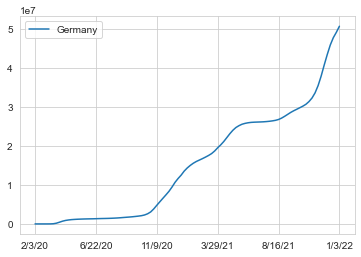

In [67]:
plotdata['Germany'].plot(legend=True)

In [45]:
# Remove data before 2/3/20 from EBI metadata
df['collection_date'] = pd.to_datetime(df['collection_date'])
df_relevant_dates = df[~(df['collection_date'] < '2020-02-03')]

In [46]:
# Get count per country over time
country_counts = df_relevant_dates.groupby(['country', 'collection_date']).size().reset_index()
country_counts.rename(columns={0 : 'count'}, inplace=True)
country_counts

,country,collection_date,count
0,Argentina,2020-05-16,1
1,Argentina,2020-06-04,23
2,Argentina,2020-09-13,2
3,Argentina,2020-09-14,8
4,Argentina,2020-09-15,2
...,...,...,...
8892,Zambia,2020-03-16,1
8893,Zimbabwe,2020-03-01,8
8894,Zimbabwe,2020-04-01,14
8895,Zimbabwe,2020-05-01,35


In [47]:
# Prepare counts: add wanted dates as index
country_counts_prepared = pd.DataFrame(index=plotdata.index.tolist())
country_counts_prepared

""
2/3/20
2/10/20
2/17/20
2/24/20
3/2/20
...
12/6/21
12/13/21
12/20/21
12/27/21


In [62]:
# Add column per country holding country count of week (according to start day of week in index)
for country in country_counts['country'].unique():
    country_counts_prepared[str(country)] = 0
    country_rows = country_counts[country_counts['country'] == country]

    for date in country_counts_prepared.index:
        date_dt = pd.to_datetime(date)
        country_rows_week = country_rows[(country_rows['collection_date'] >= date_dt)
                                         & (country_rows['collection_date'] < date_dt + pd.DateOffset(7))]
        country_counts_prepared[country][date] = country_rows_week['count'].sum()

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
country_counts_prepared.head(30)

,Argentina,Armenia,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Belize,Benin,...,USA,Uganda,United Kingdom,Uruguay,Uzbekistan,Venezuela,Viet Nam,West Bank,Zambia,Zimbabwe
2/3/20,0,0,1,0,0,0,0,3,0,0,...,1,0,0,0,0,0,0,0,0,0
2/10/20,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,5,0,0,0
2/17/20,0,0,3,0,0,0,0,0,0,0,...,28,0,0,0,0,0,0,0,0,0
2/24/20,0,0,1,0,0,0,0,0,1,0,...,299,0,10,0,0,0,0,0,0,8
3/2/20,0,0,9,0,0,0,0,0,0,0,...,346,0,71,0,2,0,0,0,0,0
3/9/20,0,0,77,0,0,0,0,1,0,1,...,2289,0,209,1,0,1,0,0,0,0
3/16/20,0,0,280,0,0,0,0,0,1,5,...,3415,0,518,0,0,2,0,0,1,0
3/23/20,0,0,434,0,0,0,0,0,1,2,...,2513,0,1428,0,0,0,0,0,0,0
3/30/20,0,0,226,0,0,0,0,0,0,1,...,2845,0,2185,0,0,0,0,0,0,14
4/6/20,0,0,183,0,0,0,0,0,1,1,...,1729,0,2060,0,0,1,0,0,0,0


<AxesSubplot:>

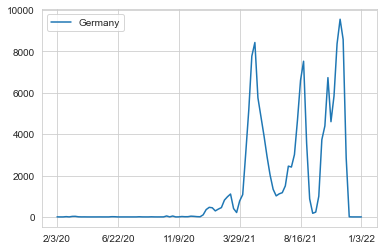

In [66]:
country_counts_prepared['Germany'].plot(legend=True)

In [133]:
# Add column for each country holding weekly #samples/#infections sum ratio
for country in countries_ts['Country/Region'].unique():
    if country in country_counts_prepared.columns:
        plotdata[f'{country}_Ratio'] = country_counts_prepared[[country]] / plotdata[[country]]
    else:
        plotdata[f'{country}_Ratio'] = 0

In [71]:
plotdata[['USA_Ratio']]

Country/Region,USA_Ratio
2/3/20,inf
2/10/20,0.023256
2/17/20,0.285714
2/24/20,2.718182
3/2/20,1.058104
...,...
12/6/21,0.000005
12/13/21,0.000000
12/20/21,0.000000
12/27/21,0.000000


In [134]:
import numpy as np

# Replace inf values with NaN values -> occur if #infection was zero
plotdata.replace([np.inf, -np.inf], 0, inplace=True)

In [135]:
# Remove columns where all values are NaNs
plotdata = plotdata.dropna(axis=1, how='all')
plotdata.head()

Country/Region,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Belize,Benin,Brazil,...,Zambia_Ratio,Zimbabwe_Ratio,China_Ratio,Canada_Ratio,France_Ratio,United Kingdom_Ratio,Australia_Ratio,Netherlands_Ratio,Denmark_Ratio,New Zealand_Ratio
2/3/20,0.0,85.1073,62.0663,76.5775,114.0413,81.6632,57.303236,0.0,11.6235,0.0,...,0.0,0.0,0.000550,0.0,0.000000,0.000000,0.026316,NaN,NaN,NaN
2/10/20,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,7.000000,0.0,0.0000,0.0,...,NaN,NaN,0.000066,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN
2/17/20,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,7.000000,0.0,0.0000,0.0,...,NaN,NaN,0.000023,0.0,0.000000,0.000000,0.028571,NaN,NaN,NaN
2/24/20,0.0,0.0000,4.0000,57.0000,0.0000,0.0000,7.000000,0.0,0.0000,1.0,...,NaN,0.0,0.000035,0.0,0.880435,0.050761,0.009524,0.000000,NaN,0.0
3/2/20,2.0,4.0000,97.0000,307.0000,0.0000,11.0000,49.000000,0.0,0.0000,14.0,...,NaN,NaN,0.000011,0.0,0.000984,0.086165,0.044335,1.214286,0.0,0.5


In [ ]:
import os

if not os.path.isdir('../plots/n_samples_by_infections_weekly'):
    os.mkdir('../plots/n_samples_by_infections_weekly')

In [136]:
plotdata.index = pd.to_datetime(plotdata.index)

# Remove even more weeks
plotdata = plotdata[plotdata.index > '2020-03-30']

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate one line plot per country showing #samples/#infections week-wise over time
sns.set_style('whitegrid')
for country in countries_ts['Country/Region'].unique():
    if country not in country_counts_prepared.columns: continue

    fig, ax = plt.subplots(figsize=(26, 12))
    plotdata[f'{country}_Ratio'].plot(style='-o')

    fig.suptitle(f'Weekly Sample Count of {country} - Scaled by Weekly Number of Infections', fontsize=22)
    plt.xlabel('Start Date of Week', fontsize=18)
    plt.ylabel('Scaled Count', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    fig.savefig(f'../plots/n_samples_by_infections_weekly/weekly_count_by_infections_{country}.png', dpi=300)
    plt.close()

### Number of Samples in Relation to Number of Infections per Country: Shifted Week-wise over Time

In [141]:
infection_cols = plotdata.columns[~plotdata.columns.str.endswith('_Ratio')]
infection_cols_new = [(col, col + '_Infections') for col in infection_cols]
plotdata.rename(columns=dict(infection_cols_new), inplace=True)
plotdata.columns

Index(['Argentina_Infections', 'Armenia_Infections', 'Austria_Infections',
       'Bahrain_Infections', 'Bangladesh_Infections', 'Belarus_Infections',
       'Belgium_Infections', 'Belize_Infections', 'Benin_Infections',
       'Brazil_Infections',
       ...
       'Zambia_Ratio', 'Zimbabwe_Ratio', 'China_Ratio', 'Canada_Ratio',
       'France_Ratio', 'United Kingdom_Ratio', 'Australia_Ratio',
       'Netherlands_Ratio', 'Denmark_Ratio', 'New Zealand_Ratio'],
      dtype='object', name='Country/Region', length=200)

In [165]:
# Add column with shifted number of infections for all countries (shifts one week "to the front")
cols_to_shift = plotdata.loc[:, plotdata.columns.str.endswith('_Infections')]

for col in cols_to_shift:
    plotdata[f'{col}_Shifted'] = plotdata[col].shift(periods=-1)

plotdata[['USA_Infections', 'USA_Infections_Shifted']]  # -> infections numbers are shifted by one row from now on

Country/Region,USA_Infections,USA_Infections_Shifted
2020-04-06,2457384.0,3987594.0
2020-04-13,3987594.0,5389279.0
2020-04-20,5389279.0,6812573.0
2020-04-27,6812573.0,8158092.0
2020-05-04,8158092.0,9363735.0
...,...,...
2021-12-06,344219054.0,350134363.0
2021-12-13,350134363.0,356965259.0
2021-12-20,356965259.0,367941229.0
2021-12-27,367941229.0,390034885.0


In [ ]:
country_counts_prepared.index = pd.to_datetime(country_counts_prepared.index)

# Add columns with sample count per country
for country in country_counts_prepared.columns:
    plotdata[f'{country}_Count'] = country_counts_prepared[country]

In [167]:
# Add column for each country holding SHIFTED weekly #samples/#infections sum ratio
for country in countries_ts['Country/Region'].unique():
    if country in country_counts_prepared.columns:
        plotdata[f'{country}_Ratio_Shifted'] = plotdata[f'{country}_Count'] / plotdata[f'{country}_Infections_Shifted']
    else:
        plotdata[f'{country}_Ratio_Shifted'] = 0

plotdata[['Germany_Count', 'Germany_Infections', 'Germany_Infections_Shifted', 'Germany_Ratio', 'Germany_Ratio_Shifted']]

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


Country/Region,Germany_Count,Germany_Infections,Germany_Infections_Shifted,Germany_Ratio,Germany_Ratio_Shifted
2020-04-06,2,696501.0,889298.0,2.871496e-06,2.248965e-06
2020-04-13,0,889298.0,1013625.0,0.000000e+00,0.000000e+00
2020-04-20,0,1013625.0,1102620.0,0.000000e+00,0.000000e+00
2020-04-27,0,1102620.0,1159038.0,0.000000e+00,0.000000e+00
2020-05-04,0,1159038.0,1203066.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...
2021-12-06,5,43457153.0,45919559.0,1.150559e-07,1.088861e-07
2021-12-13,0,45919559.0,47803360.0,0.000000e+00,0.000000e+00
2021-12-20,0,47803360.0,49186678.0,0.000000e+00,0.000000e+00
2021-12-27,0,49186678.0,50737108.0,0.000000e+00,0.000000e+00


In [170]:
# Replace inf values with NaN values -> occur if #infection was zero
plotdata.replace([np.inf, -np.inf], 0, inplace=True)

In [42]:
if not os.path.isdir('../plots/n_samples_by_infections_weekly_shifted'):
    os.mkdir('../plots/n_samples_by_infections_weekly_shifted')

In [171]:
sns.set_style('whitegrid')

# Generate one line plot per country showing #samples/#infections week-wise shifted over time
for country in countries_ts['Country/Region'].unique():
    if country not in country_counts_prepared.columns: continue

    fig, ax = plt.subplots(figsize=(24, 12))
    plotdata[f'{country}_Ratio_Shifted'].plot(style='-o')

    fig.suptitle(f'Weekly Sample Count of {country} - Scaled by Weekly Number of Infections from Week Before', fontsize=22)
    plt.xlabel('Start Date of Week', fontsize=18)
    plt.ylabel('Scaled Count', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    fig.savefig(f'../plots/n_samples_by_infections_weekly_shifted/weekly_count_by_last_weeks_infections_{country}.png', dpi=300)
    plt.close()

In [174]:
plotdata.to_csv('../data/weekly_sample_and_infection_counts_of_countries.csv')
# can be read with: pd.read_csv('../data/weekly_sample_and_infection_counts_of_countries.csv', index_col=0)

## Investigation of Temporal Bias

In [18]:
plotdata = df.copy(deep=True)
plotdata['collection_date'] = pd.to_datetime(plotdata['collection_date'])

In [3]:
import os

if not os.path.isdir('../plots/n_samples_over_time'):
    os.mkdir('../plots/n_samples_over_time')

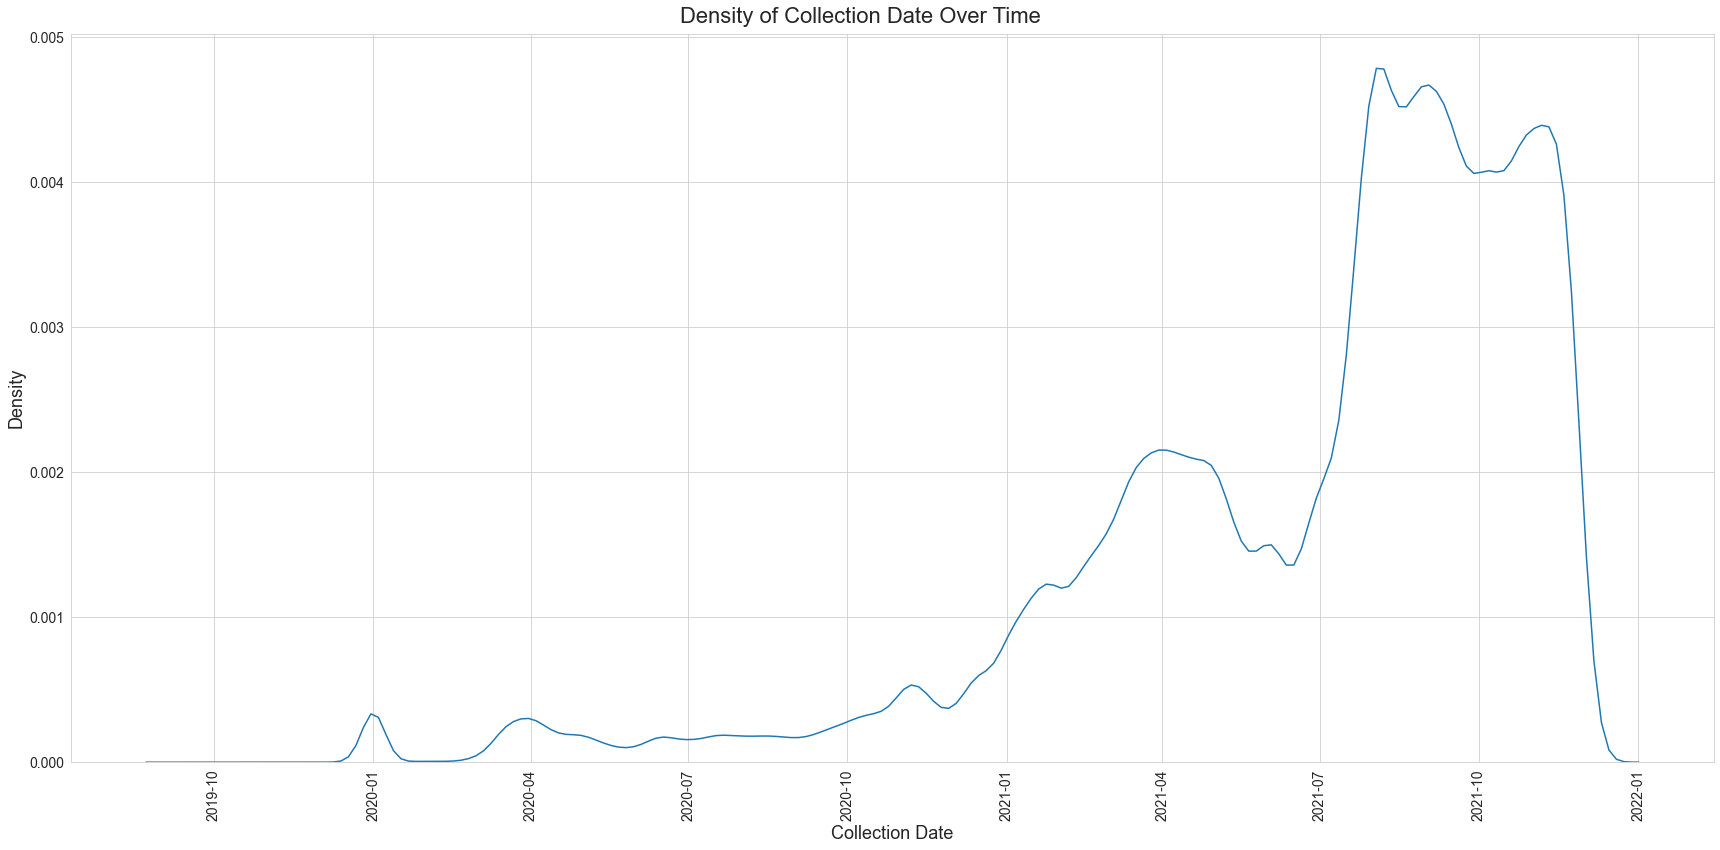

In [19]:
# A) Plot density
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.kdeplot(data=plotdata,
            x='collection_date') #,
            #hue='keywords')
fig.suptitle('Density of Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/n_samples_over_time/collection_date_density.png', dpi=300)
plt.close()

In [20]:
# B) Plot absolute count
date_counts = plotdata.groupby(['collection_date']).count().sum(axis=1)
# date_counts = plotdata.groupby(['collection_date', 'keywords']).count().sum(axis=1)
date_counts = pd.DataFrame(date_counts, columns=['Count'])
date_counts.sort_values(by='Count', ascending=False)

,Count
collection_date,
2021-08-31,443839
2021-09-07,414717
2021-08-03,405730
2021-08-02,394096
2021-08-05,391909
...,...
2020-01-09,23
2019-09-12,23
2020-01-11,22


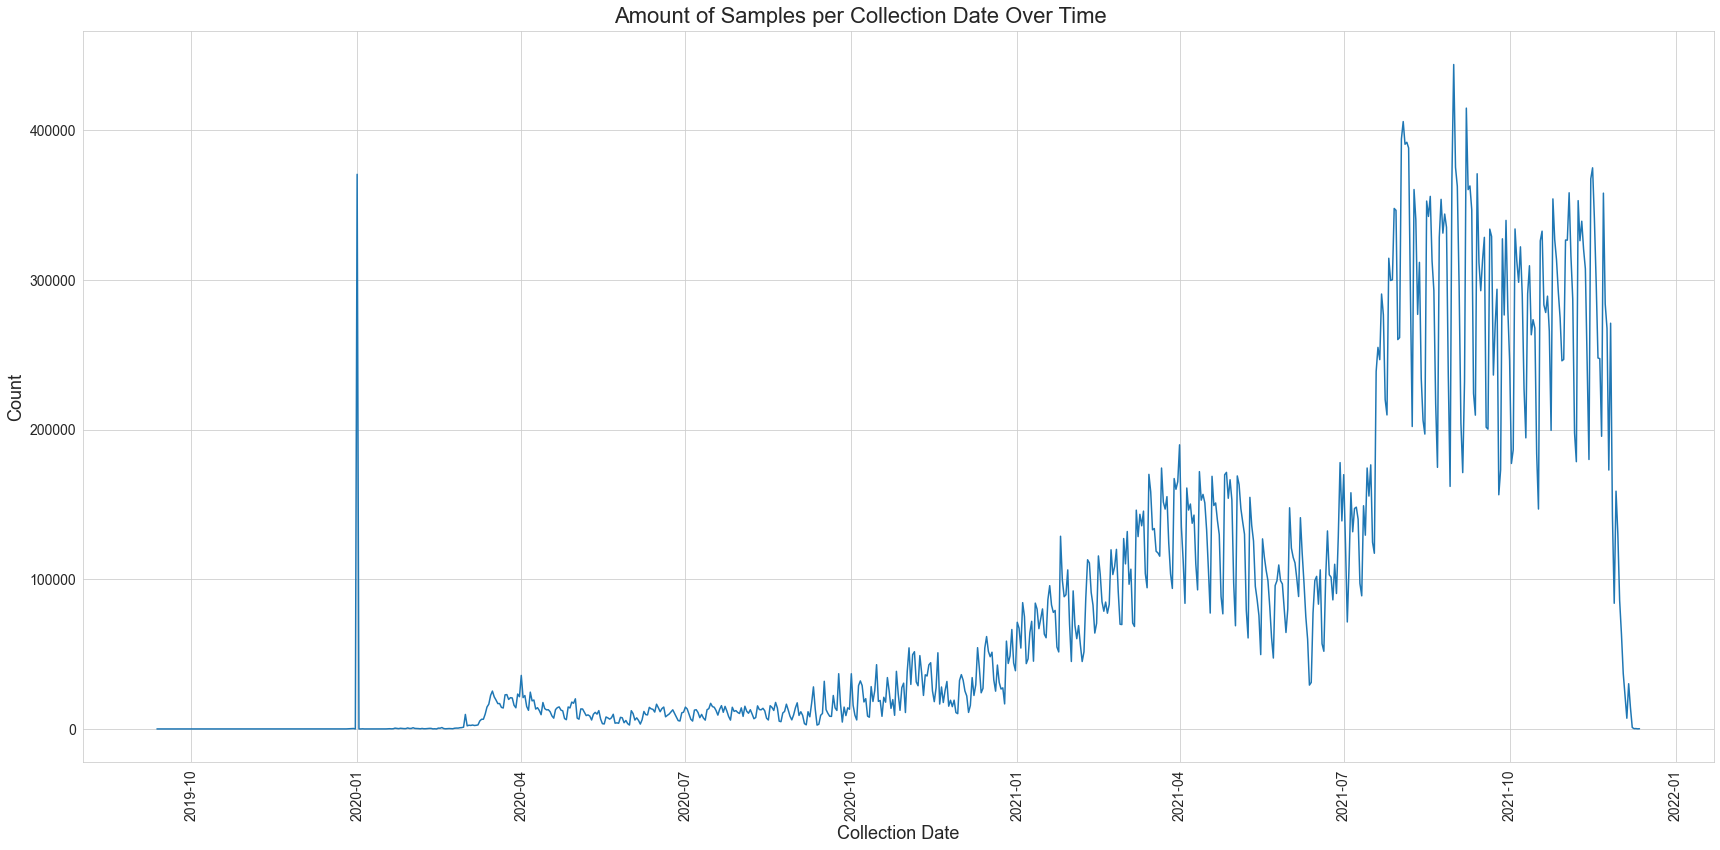

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.lineplot(x=date_counts.index, #.get_level_values(0),
             y=date_counts['Count']) #,
             #hue=date_counts.index.get_level_values(1))
fig.suptitle('Amount of Samples per Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/n_samples_over_time/collection_date_count.png', dpi=300)
plt.close()

# -> temporal bias around April 2021 and Winter 2021
# -> amount of sequences was doubled in Winter in comparison to warmer months
# -> amount of sequences decreases in the end probably because original TSV is not up-to-date

In [22]:
# Filter for January 2020
date_counts[(date_counts.index.month == 1) & (date_counts.index.year == 2020)]

# -> a lot of sequences on New Year's Day 2020 in UK and Switzerland
# -> probably typo and 2021 is meant: UK had deflection around 9th January 2021 regarding number of cases
# -> but not explainable at all for Switzerland

,Count
collection_date,
2020-01-01,370504
2020-01-02,67
2020-01-03,23
2020-01-04,105
2020-01-05,23
2020-01-07,23
2020-01-08,66
2020-01-09,23
2020-01-10,47


In [16]:
min(date_counts.index)

Timestamp('2019-09-12 00:00:00')

In [9]:
max(date_counts.index)

Timestamp('2021-12-12 00:00:00')

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot collection data count per country
for country in plotdata['country'].unique():
    plotdata_country = plotdata[plotdata['country'] == country]
    date_counts_country = plotdata_country.groupby(['collection_date']).count().sum(axis=1)
    date_counts_country = pd.DataFrame(date_counts_country, columns=['Count'])

    sns.set_style('whitegrid')
    fig, _ = plt.subplots(figsize=(24, 12))
    sns.lineplot(x=date_counts_country.index,
                 y=date_counts_country['Count'])
    fig.suptitle(f'Amount of Samples per Collection Date Over Time in {country}', fontsize=22)
    plt.xlabel('Collection Date', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    fig.savefig(f'../plots/n_samples_over_time/collection_date_count_{str(country).replace(" ", "_")}.png', dpi=300)
    plt.close()

# -> USA: raise of cases from end of October 2020 until February 2021 not recognisable
# -> UK: curve fits well
# -> Germany: same like for the USA + number of tests should be much higher since November 2021

## Investigation of Existing Ages

In [174]:
original_len = len(df)
original_len  # 2,520,583

2520583

In [38]:
# Count how many samples do contain (valuable) information about age
df_with_ages = df[df['age'].notna()]
len(df_with_ages)  # 9,948

9948

In [34]:
# Show how age is set for patients with age information given in days or months
df_with_ages[df_with_ages['host'].str.contains('day|months|mos|MOS')][['age', 'host']]

,age,host
993150,0.67,Homo sapiens; Male age 8 months
993264,0.33,Homo sapiens; Female age 4 months
993296,0.25,Homo sapiens; Male age 3 months
993677,0.14,Homo sapiens; Male age 50 days
993775,0.08,Homo sapiens; Female age 1 months
993802,0.83,Homo sapiens; Female age 10 months
993970,0.92,Homo sapiens; Female age 11 months
994025,0.58,Homo sapiens; Female age 7 months
994601,0.92,Homo sapiens; Female age 11 months
994679,0.42,Homo sapiens; Female age 5 months


In [140]:
# Check how host is set if age in not numeric and host is not equal to main value "homo sapiens" (for debugging and to finally check all set ages)
df['age'] = df['age'].astype(str)
non_numeric_ages = df[df['age'].apply(lambda x: not x.isnumeric())]
non_numeric_ages[non_numeric_ages['host'].str.lower() != 'homo sapiens'][['age', 'host']]

,age,host
460,nan,"Homo sapiens, female"
461,nan,"Homo sapiens, male"
462,nan,"Homo sapiens, male"
463,nan,"Homo sapiens, female"
464,nan,"Homo sapiens, male"
...,...,...
2242394,nan,NaN
2252312,nan,NaN
2474640,nan,not provided
2496096,nan,not provided


In [ ]:
# Convert ages to integers for simpler plotting
df_with_ages['age'] = df_with_ages['age'].astype(int)

In [41]:
# Sort by age
plotdata = df_with_ages.sort_values(by=['age'])

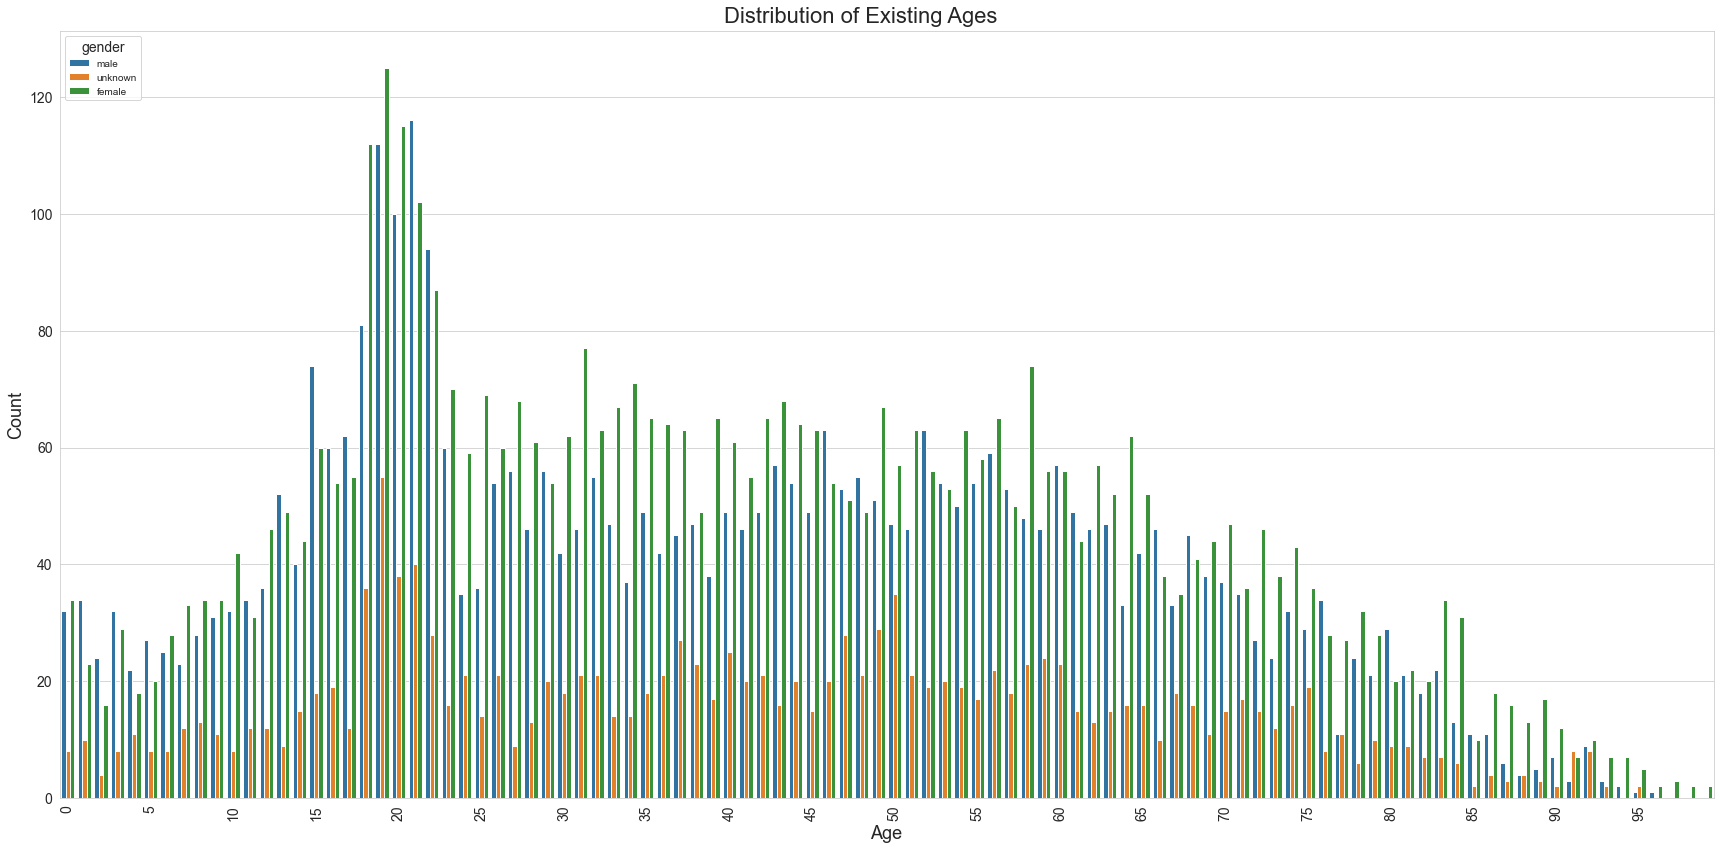

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.countplot(data=plotdata,
              x='age',
              hue='gender')
fig.suptitle('Distribution of Existing Ages', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show only every 5th x-tick (aka every 5th age on x-axis)
for i, label in enumerate(ax.get_xticklabels()):
    if i % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()
fig.savefig('../plots/age_distribution.png', dpi=300)
plt.close()

In [50]:
plotdata['country'].value_counts()

USA               9656
Russia             265
Italy               10
Czech Republic       6
Germany              5
China                5
Pakistan             1
Name: country, dtype: int64

In [ ]:
import os

if not os.path.isdir('../plots/age_distribution'):
    os.mkdir('../plots/age_distribution')

In [ ]:
# Ensure that age distribution won't change for USA and check if other countries show interesting distributions
for country, age_count in plotdata['country'].value_counts().iteritems():
    fig, ax = plt.subplots(figsize=(24, 12))
    sns.countplot(data=plotdata[plotdata['country'] == country],
                  x='age',
                  hue='gender')
    fig.suptitle(f'Distribution of Existing Ages in {country}\n ({age_count} ages available)', fontsize=22)
    plt.xlabel('Age', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Show only every 5th x-tick
    for i, label in enumerate(ax.get_xticklabels()):
        if i % 5 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.tight_layout()
    fig.savefig(f'../plots/age_distribution/age_distribution_{country}.png', dpi=300)
    plt.close()

# USA:
# -> similiar to real-world age distribution, especially regarding rise around 20
# -> see e.g. https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/
# -> a bit more female samples are also quite realistic

# RUSSIA:
# -> russian ages are mostly between 63 and 83